In [184]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats            # Basic package for basic univariate regressions
import statsmodels.api as sm           # More sophisticated package for univariate and multivariate regressions
import statsmodels.formula.api as smf
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
from re import sub
from decimal import Decimal

# Import Data

In [3]:
def filereader(file):
    f = open(file, 'r')
    f_list = f.readlines()
    f.close()
    f_list = [element.replace('-','') for element in f_list]
    f_list = [element.rstrip().split(',') for element in f_list][0:]
    return f_list

In [4]:
listings = filereader('listings (1).csv')
header = listings[0] #list of all col names

In [5]:
data = pd.read_csv('listings (1).csv') #read in csv

In [7]:
data1 = data.values #numpy array of all records 

In [216]:
host_id = data1[:,0]
host_verifications = data1[:, 34]
neighbourhood_cleansed = data1[:, 39]
property_type = data1[:, 51]
room_type = data1[:, 52]
accommodates = data1[:, 53]
bathrooms = data1[:, 54]
bedrooms = data1[:, 55]
beds = data1[:, 56]
amenities = data1[:, 58]
price = data1[:, 60]
availability_30 = data1[:, 77]
availability_60 = data1[:, 78]
availability_90 = data1[:, 79]
availability_365 = data1[:, 80]
review_scores_rating = data1[:, 86]
review_scores_accuracy = data1[:, 87]
review_scores_cleanliness = data1[:, 88]
review_scores_checkin = data1[:, 89]
review_scores_communication = data1[:, 90]
review_scores_location = data1[:, 91]
review_scores_value = data1[:, 92]

In [9]:
booked = 90-availability_90 # number of nights sold in the upcomming 90 days

In [10]:
income = booked * price #income in the upcomming 90 days

In [ ]:
percent_booked = booked / 90 #percentage booked in the upcomming 90 days

#  Normalize income on neighborhood and number of people it accomodates. I used 3 groups for accomodates: 1-2, 3-5, 6+

In [93]:
# find average income for each neighborhood and by how many folks the listing accomodates
all_hoods = ["Bayview", "Castro/Upper Market", "Bernal Heights", "Chinatown", "Diamond Heights", "Downtown/Civic Center", "Crocker Amazon", "Excelsior", "Glen Park", "Financial District", "Golden Gate Park", "Haight Ashbury", "Inner Sunset", "Inner Richmond", "Mission", "Marina", "Lakeshore", "Noe Valley", "North Beach", "Nob Hill", "Outer Mission", "Outer Richmond", "Ocean View", "Pacific Heights", "Outer Sunset", "Parkside", "Presidio Heights", "Potrero Hill", "Presidio", "Russian Hill", "South of Market", "Treasure Island/YBI", "Seacliff", "Twin Peaks", "Visitacion Valley", "Western Addition", "West of Twin Peaks"]
avg_hood_income_1_2 = {}
avg_hood_income_3_5 = {}
avg_hood_income_6 = {}
# InnerSunset12_income = []
# InnerSunset12_incomeID = []
for index, element in enumerate(income): 
    if accommodates[index] <= 2:
        if neighbourhood_cleansed[index] not in avg_hood_income_1_2:
            #create in our dict {"Bayview":[totalprice,#listing]}
            avg_hood_income_1_2[neighbourhood_cleansed[index]] = [element, 1]
#             if neighbourhood_cleansed[index] == "Inner Sunset":
#                 InnerSunset12_income.append(element)
#                 InnerSunset12_incomeID.append(host_id[index])
        else:
            info = avg_hood_income_1_2[neighbourhood_cleansed[index]]
            info[0] = info[0]+element
            info[1] = info[1]+1
            avg_hood_income_1_2[neighbourhood_cleansed[index]] = info
#             if neighbourhood_cleansed[index] == "Inner Sunset":
#                 InnerSunset12_income.append(element)
#                 InnerSunset12_incomeID.append(host_id[index])
            
    if accommodates[index] > 2 and accommodates[index] < 6: 
        if neighbourhood_cleansed[index] not in avg_hood_income_3_5:
            #create in our dict {"Bayview":[totalprice,#listing]}
            avg_hood_income_3_5[neighbourhood_cleansed[index]] = [element, 1]
        else:
            info = avg_hood_income_3_5[neighbourhood_cleansed[index]]
            info[0] = info[0]+element
            info[1] = info[1]+1
            
    if accommodates[index] > 6: 
        if neighbourhood_cleansed[index] not in avg_hood_income_6:
            #create in our dict {"Bayview":[totalprice,#listing]}
            avg_hood_income_6[neighbourhood_cleansed[index]] = [element, 1]
        else:
            info = avg_hood_income_6[neighbourhood_cleansed[index]]
            info[0] = info[0]+element
            info[1] = info[1]+1

In [97]:
# Normalize income metric by diving income by approiate average
income_cleansed = np.array([])
for index, element in enumerate(income): 
    hood = neighbourhood_cleansed[index]
    accom = accommodates[index]
    if accom <= 2:
        hood_info = avg_hood_income_1_2[hood]
        avg = hood_info[0] / hood_info[1]
        income_cleansed = np.append(income_cleansed, element/avg)
    elif accom > 2 and accom < 6:
        hood_info = avg_hood_income_3_5[hood]
        avg = hood_info[0] / hood_info[1]
        income_cleansed = np.append(income_cleansed, element/avg)
    elif accom > 6:
        hood_info = avg_hood_income_6[hood]
        avg = hood_info[0] / hood_info[1]
        income_cleansed = np.append(income_cleansed, element/avg)
    else:
        income_cleansed = np.append(income_cleansed, None) #we will throw away the incomes we couldnt normalize

# Normalize price

In [99]:
# find average income for each neighborhood and by how many folks the listing accomodates
all_hoods = ["Bayview", "Castro/Upper Market", "Bernal Heights", "Chinatown", "Diamond Heights", "Downtown/Civic Center", "Crocker Amazon", "Excelsior", "Glen Park", "Financial District", "Golden Gate Park", "Haight Ashbury", "Inner Sunset", "Inner Richmond", "Mission", "Marina", "Lakeshore", "Noe Valley", "North Beach", "Nob Hill", "Outer Mission", "Outer Richmond", "Ocean View", "Pacific Heights", "Outer Sunset", "Parkside", "Presidio Heights", "Potrero Hill", "Presidio", "Russian Hill", "South of Market", "Treasure Island/YBI", "Seacliff", "Twin Peaks", "Visitacion Valley", "Western Addition", "West of Twin Peaks"]
avg_hood_price_1_2 = {}
avg_hood_price_3_5 = {}
avg_hood_price_6 = {}

for index, element in enumerate(price): 
    if accommodates[index] <= 2:
        if neighbourhood_cleansed[index] not in avg_hood_price_1_2:
            #create in our dict {"Bayview":[totalprice,#listing]}
            avg_hood_price_1_2[neighbourhood_cleansed[index]] = [element, 1]
        else:
            info = avg_hood_price_1_2[neighbourhood_cleansed[index]]
            info[0] = info[0]+element
            info[1] = info[1]+1
            avg_hood_price_1_2[neighbourhood_cleansed[index]] = info            
    if accommodates[index] > 2 and accommodates[index] < 6: 
        if neighbourhood_cleansed[index] not in avg_hood_price_3_5:
            #create in our dict {"Bayview":[totalprice,#listing]}
            avg_hood_price_3_5[neighbourhood_cleansed[index]] = [element, 1]
        else:
            info = avg_hood_price_3_5[neighbourhood_cleansed[index]]
            info[0] = info[0]+element
            info[1] = info[1]+1
            
    if accommodates[index] > 6: 
        if neighbourhood_cleansed[index] not in avg_hood_price_6:
            #create in our dict {"Bayview":[totalprice,#listing]}
            avg_hood_price_6[neighbourhood_cleansed[index]] = [element, 1]
        else:
            info = avg_hood_price_6[neighbourhood_cleansed[index]]
            info[0] = info[0]+element
            info[1] = info[1]+1

37


In [101]:
# Normalize income metric by diving income by approiate average
price_cleansed = np.array([])
for index, element in enumerate(price): 
    hood = neighbourhood_cleansed[index]
    accom = accommodates[index]
    if accom <= 2:
        hood_info = avg_hood_price_1_2[hood]
        avg = hood_info[0] / hood_info[1]
        price_cleansed = np.append(price_cleansed, element/avg)
    elif accom > 2 and accom < 6:
        hood_info = avg_hood_price_3_5[hood]
        avg = hood_info[0] / hood_info[1]
        price_cleansed = np.append(price_cleansed, element/avg)
    elif accom > 6:
        hood_info = avg_hood_price_6[hood]
        avg = hood_info[0] / hood_info[1]
        price_cleansed = np.append(price_cleansed, element/avg)
    else:
        price_cleansed = np.append(price_cleansed, None) #we will throw away the incomes we couldnt normalize

## Single Linear Regression:

In [105]:
def reg_m(y, x):
    X = np.hstack((np.ones((len(x),1)), x))     # adds column of ones to X to estimate the intercept
    results = sm.OLS(y, X).fit()                # creates object containing regression results
    return results

In [139]:
all_fields = [bathrooms, bedrooms, beds, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value]
all_fields_names = ["bathrooms", "bedrooms", "beds", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value"]

Control for variations in income due to the amenities a propety has --> only consider listings that have at least 50% of these basic amenities

In [196]:
#amenities_control = [tv, internet, wifi, kitchen, refrigerator, dishwasher, oven, stove, washer, dryer, microwave, essentials] 
amenities_control_names = ["tv", "internet", "wifi", "kitchen", "refrigerator", "dishwasher", "oven", "stove", "washer", "dryer", "microwave", "essentials"] 

def amenities_controler(index):        
    #we are already looking at a amenities record--> amenities[5]
    record = amenities[index].lower()
    test = 0
    for i, amenitiy in enumerate(amenities_control_names): #does it have atleast 75%
        if amenitiy in record:
            test+=1
    if test==12:
        return True
    else:
        return False



In [197]:
def reg_combos(incomeORprice, new_field):
    #create new arrays to fill with cleaned data
    incomeORprice1 = np.array([])
    new_field1 = np.array([])
    
    #create data_cleaner array where True indicates a Null. 
    data_cleaner = pd.isnull(new_field)
    data_cleaner_incomeORprice = pd.isnull(incomeORprice)
    
    #clean data set of "new_field" to remove nans & remove assocaited record from income
    #i actually have an object array, not a native numpy array
    #control for neighborhood
    #control for ammeneties: 
    for index, element in enumerate(data_cleaner):
        if not(element) and not(data_cleaner_incomeORprice[index]): #remove records with nan in either array
            has_amenities = amenities_controler(index)
            if has_amenities==True:
                incomeORprice1 = np.append(incomeORprice1, incomeORprice[index])
                new_field1 = np.append(new_field1, new_field[index])
                

    #Save shapes        
    incomeORprice_shape = incomeORprice1.shape
    new_field_shape = new_field1.shape
    #reshape so dimessions of both arrays are identical. set both arrays to dtype=float
    if incomeORprice_shape==new_field_shape:
        incomeORprice1 = incomeORprice1.reshape(incomeORprice_shape[0],1)
        new_field1 = new_field1.reshape(new_field_shape[0],1)
        incomeORprice1 = np.array(incomeORprice1, dtype=float)
        new_field1 = np.array(new_field1, dtype=float)
        reg_out = reg_m(incomeORprice1, new_field1)
        #return [regression object, incomeORprice1 array for plotting, new_field1 array for plotting ]
        return [reg_out, incomeORprice1, new_field1]
        

# Example regression of review_scores_cleanliness vs price


In [198]:
ans = reg_combos(price_cleansed, review_scores_cleanliness)
regout = ans[0]
y = ans[1]
x = ans[2]
regout.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     8.781
Date:                Wed, 22 Jan 2020   Prob (F-statistic):            0.00318
Time:                        15:48:48   Log-Likelihood:                -474.59
No. Observations:                 539   AIC:                             953.2
Df Residuals:                     537   BIC:                             961.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0427      0.378     -0.113      0.910      -0.785       0.700
x1             0.1152      0.039      2.963      0.003       0.039       0.192
==============================================================================
Omnibus:                      342.336   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4523.154
Skew:                           2.580   Prob(JB):                         0.00
Kurtosis:                      16.220   Cond. No.                         147.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

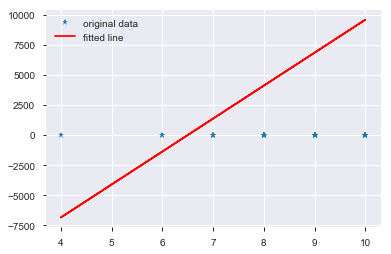

In [199]:
plt.plot(x, y, '*', label='original data')
plt.plot(x, reg_out.params[0] + reg_out.params[1]*x, 'r', label='fitted line')
plt.legend()
plt.show()

# Price vs...
Finding the relationship of pirce in the upcomming 90 days with 10 fields: bathrooms, bedrooms, beds, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value

In [200]:
r2_price_singleReg = []
for i, new_field in enumerate(all_fields):
    reg_out_all = reg_combos(price_cleansed, new_field)
    r2_price_singleReg.append(reg_out_all)
    #print("--------------------")
    #print("--------------------")
    #print("This is a single regression of price vs".upper(), all_fields_names[i].upper())
    
    #print(reg_out_all[0].summary()) ### -->> code to print full regression summary
    
    
    print("{:<12} {:7.4f}".format(all_fields_names[i], reg_out_all[0].rsquared)) ### -->> code to print just r2 values
    
#     y = reg_out_all[1]
#     x = reg_out_all[2]
#     plt.plot(x, y, '*', label='original data')
#     plt.plot(x, reg_out.params[0] + reg_out.params[1]*x, 'r', label='fitted line')
#     plt.legend()
#     plt.show()

bathrooms     0.0020
bedrooms      0.0346
beds          0.0138
review_scores_rating  0.0124
review_scores_accuracy  0.0087
review_scores_cleanliness  0.0161
review_scores_checkin  0.0026
review_scores_communication  0.0014
review_scores_location  0.0028
review_scores_value  0.0004


# % Income vs...
Finding the relationship of income in the upcomming 90 days with 10 fields: accommodates, bathrooms, bedrooms, beds, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value

In [153]:
r2_income_singleReg = []
for i, new_field in enumerate(all_fields):
    reg_out_all = reg_combos(income_cleansed, new_field)
    r2_income_singleReg.append(reg_out_all)
#     print("--------------------")
#     print("--------------------")
#     print("This is a single regression of price vs".upper(), all_fields_names[i].upper())
    
#     print(reg_out_all[0].summary()) ### -->> code to print full regression summary
    
    print("{:<12} {:7.4f}".format(all_fields_names[i], reg_out_all[0].rsquared)) ### -->> code to print just r2 values


bathrooms     0.0043
bedrooms      0.0187
beds          0.0079
review_scores_rating  0.0071
review_scores_accuracy  0.0070
review_scores_cleanliness  0.0023
review_scores_checkin  0.0158
review_scores_communication  0.0037
review_scores_location  0.0012
review_scores_value  0.0028


# Multiple Regression with different review metrics

In [154]:
review_scores_rating = data1[:, 86]
review_scores_accuracy = data1[:, 87]
review_scores_cleanliness = data1[:, 88]
review_scores_checkin = data1[:, 89]
review_scores_communication = data1[:, 90]
review_scores_location = data1[:, 91]
review_scores_value = data1[:, 92]

In [291]:
def mult_reg(incomeORprice):
    #create new arrays to fill with cleaned data
    income1 = np.array([])
    new_field1 = np.array([])
    new_field2 = np.array([])
    new_field3 = np.array([])
    new_field4 = np.array([])
    new_field5 = np.array([])
    new_field6 = np.array([])
    new_field7 = np.array([])
    #create data_cleaner array where True indicates a Null. 
    data_cleaner0 = pd.isnull(incomeORprice)
    data_cleaner1 = pd.isnull(review_scores_rating)
    data_cleaner2 = pd.isnull(review_scores_accuracy)
    data_cleaner3 = pd.isnull(review_scores_cleanliness)
    data_cleaner4 = pd.isnull(review_scores_checkin)
    data_cleaner5 = pd.isnull(review_scores_communication)
    data_cleaner6 = pd.isnull(review_scores_location)
    data_cleaner7 = pd.isnull(review_scores_value)
    
    #remove nulls
    for index, element in enumerate(data_cleaner0):
            if not(element) and not(data_cleaner1[index])and not(data_cleaner2[index]) and not(data_cleaner3[index]) and not(data_cleaner4[index]) and not(data_cleaner5[index]) and not(data_cleaner6[index]) and not(data_cleaner7[index]):
                income1 = np.append(income1, incomeORprice[index])
                new_field1 = np.append(new_field1, review_scores_rating[index])
                new_field2 = np.append(new_field2, review_scores_accuracy[index])
                new_field3 = np.append(new_field3, review_scores_cleanliness[index])
                new_field4 = np.append(new_field4, review_scores_checkin[index])
                new_field5 = np.append(new_field5, review_scores_communication[index])
                new_field6 = np.append(new_field6, review_scores_location[index])
                new_field7 = np.append(new_field7, review_scores_value[index])
    
    #Save shapes        
    income_shape = income1.shape
    new_field_shape = new_field1.shape
    income1 = income1.reshape(income_shape[0],1)
    new_field1 = new_field1.reshape(new_field_shape[0],1)
    new_field2 = new_field2.reshape(new_field_shape[0],1)
    new_field3 = new_field3.reshape(new_field_shape[0],1)
    new_field4 = new_field4.reshape(new_field_shape[0],1)
    new_field5 = new_field5.reshape(new_field_shape[0],1)
    new_field6 = new_field6.reshape(new_field_shape[0],1)
    new_field7 = new_field7.reshape(new_field_shape[0],1)
    income1 = np.array(income1, dtype=float)
    new_field1 = np.array(new_field1, dtype=float)
    new_field2 = np.array(new_field2, dtype=float)
    new_field3 = np.array(new_field2, dtype=float)
    new_field4 = np.array(new_field2, dtype=float)
    new_field5 = np.array(new_field2, dtype=float)
    new_field6 = np.array(new_field2, dtype=float)
    new_field7 = np.array(new_field2, dtype=float)
    
    W = np.hstack((new_field1, new_field2, new_field3, new_field4, new_field5, new_field6, new_field7)) 
    reg_out = reg_m(income1, W)
    return reg_out

# Multiple Regression of Price vs every review measure

In [214]:
#multiple regression for every listing
a = mult_reg(price_cleansed).summary()
a

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     17.71
Date:                Wed, 22 Jan 2020   Prob (F-statistic):           2.15e-08
Time:                        20:05:32   Log-Likelihood:                -9130.7
No. Observations:                6043   AIC:                         1.827e+04
Df Residuals:                    6040   BIC:                         1.829e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1030      0.204     -0.506      0.613      -0.502       0.296
x1             0.0113      0.003      4.110      0.000       0.006       0.017
x2             0.0002      0.005      0.043      0.966      -0.009       0.009
x3             0.0002      0.005      0.043      0.966      -0.009       0.009
x4             0.0002      0.005      0.043      0.966      -0.009       0.009
x5             0.0002      0.005      0.043      0.966      -0.009       0.009
x6             0.0002      0.005      0.043      0.966      -0.009       0.009
x7             0.0002      0.005      0.043      0.966      -0.009       0.009
==============================================================================
Omnibus:                    13749.750   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        126451901.542
Skew:                          21.525   Prob(JB):                         0.00
Kurtosis:                     710.358   Cond. No.                     1.62e+82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.23e-157. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Multiple Regression of Income vs every review measure

In [171]:
#multiple regression for every listing
a = mult_reg(income_cleansed).summary()
a

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     34.58
Date:                Wed, 22 Jan 2020   Prob (F-statistic):           1.17e-15
Time:                        15:19:53   Log-Likelihood:                -10706.
No. Observations:                6043   AIC:                         2.142e+04
Df Residuals:                    6040   BIC:                         2.144e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9736      0.264     -3.686      0.000      -1.491      -0.456
x1             0.0194      0.004      5.446      0.000       0.012       0.026
x2             0.0029      0.006      0.464      0.643      -0.009       0.015
x3             0.0029      0.006      0.464      0.643      -0.009       0.015
x4             0.0029      0.006      0.464      0.643      -0.009       0.015
x5             0.0029      0.006      0.464      0.643      -0.009       0.015
x6             0.0029      0.006      0.464      0.643      -0.009       0.015
x7             0.0029      0.006      0.464      0.643      -0.009       0.015
==============================================================================
Omnibus:                    11347.048   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32644562.347
Skew:                          13.980   Prob(JB):                         0.00
Kurtosis:                     361.981   Cond. No.                     1.62e+82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.23e-157. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Summary Stats using pandas_profiling

In [ ]:
df = pd.read_csv('listings (1).csv') #read in csv

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [ ]:
report = ProfileReport(df)
report.to_file('profile_report.html')

# Polynomial Regressions with 2 degress of freedom

In [185]:
def reg_combos(incomeORprice, new_field):
    #create new arrays to fill with cleaned data
    incomeORprice1 = np.array([])
    new_field1 = np.array([])
    
    #create data_cleaner array where True indicates a Null. 
    data_cleaner = pd.isnull(new_field)
    data_cleaner_incomeORprice = pd.isnull(incomeORprice)
    
    #clean data set of "new_field" to remove nans & remove assocaited record from income
    #i actually have an object array, not a native numpy array
    #control for neighborhood
    #control for ammeneties: 
    for index, element in enumerate(data_cleaner):
        if not(element) and not(data_cleaner_incomeORprice[index]): #remove records with nan in either array
            has_amenities = amenities_controler(index)
            if has_amenities==True:
                incomeORprice1 = np.append(incomeORprice1, incomeORprice[index])
                new_field1 = np.append(new_field1, new_field[index])
                

    
    #data must be one dimensional. set both arrays to dtype=float
    
    incomeORprice1 = np.array(incomeORprice1, dtype=float)
    new_field1 = np.array(new_field1, dtype=float)

    degree = 2

    df = pd.DataFrame(columns=['y', 'x'])
    df['x'] = new_field1
    df['y'] = incomeORprice1

    weights = np.polyfit(new_field1, incomeORprice1, degree)
    model = np.poly1d(weights)
    results = smf.ols(formula='y ~ model(x)', data=df).fit()


        #return [regression object, incomeORprice1 array for plotting, new_field1 array for plotting ]
    return [results, incomeORprice1, new_field1]
        

# Example polynomial regression with price and review_scores_cleanliness

In [192]:
ans = reg_combos(price_cleansed, review_scores_cleanliness)
regout = ans[0]
y = ans[1]
x = ans[2]
regout.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     11.85
Date:                Wed, 22 Jan 2020   Prob (F-statistic):           0.000623
Time:                        15:43:59   Log-Likelihood:                -473.08
No. Observations:                 539   AIC:                             950.2
Df Residuals:                     537   BIC:                             958.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -1.75e-14      0.313  -5.59e-14      1.000      -0.615       0.615
model(x)       1.0000      0.291      3.442      0.001       0.429       1.571
==============================================================================
Omnibus:                      342.785   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4550.103
Skew:                           2.583   Prob(JB):                         0.00
Kurtosis:                      16.263   Cond. No.                         25.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

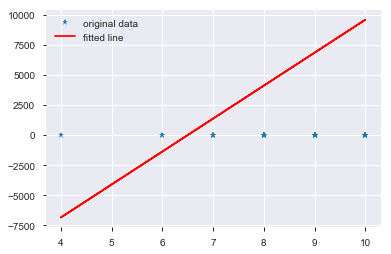

In [188]:
plt.plot(x, y, '*', label='original data')
plt.plot(x, reg_out.params[0] + reg_out.params[1]*x, 'r', label='fitted line')
plt.legend()
plt.show()

# Polynomical Regression of Price vs all fields...


In [194]:
r2_price_singlePolyReg = []
for i, new_field in enumerate(all_fields):
    reg_out_all = reg_combos(price_cleansed, new_field)
    r2_price_singlePolyReg.append(reg_out_all)
    #print("--------------------")
    #print("--------------------")
    #print("This is a single regression of price vs".upper(), all_fields_names[i].upper())
    
    #print(reg_out_all[0].summary()) ### -->> code to print full regression summary
    
    
    print("{:<12} {:7.4f}".format(all_fields_names[i], reg_out_all[0].rsquared)) ### -->> code to print just r2 values
    
#     y = reg_out_all[1]
#     x = reg_out_all[2]
#     plt.plot(x, y, '*', label='original data')
#     plt.plot(x, reg_out.params[0] + reg_out.params[1]*x, 'r', label='fitted line')
#     plt.legend()
#     plt.show()

bathrooms     0.0275
bedrooms      0.0359
beds          0.0142
review_scores_rating  0.0161
review_scores_accuracy  0.0137
review_scores_cleanliness  0.0216
review_scores_checkin  0.0032
review_scores_communication  0.0015
review_scores_location  0.0031
review_scores_value  0.0011


In [ ]:
review_names = ["Accuracy", "Cleanliness", "Checkin", "Communication", "Location", "Value"]
review_averages = [9.759248029, 9.611734384, 9.852463988, 9.825829923, 9.688400303, 9.383320697]

AttributeError: module 'matplotlib.pyplot' has no attribute 'sort'

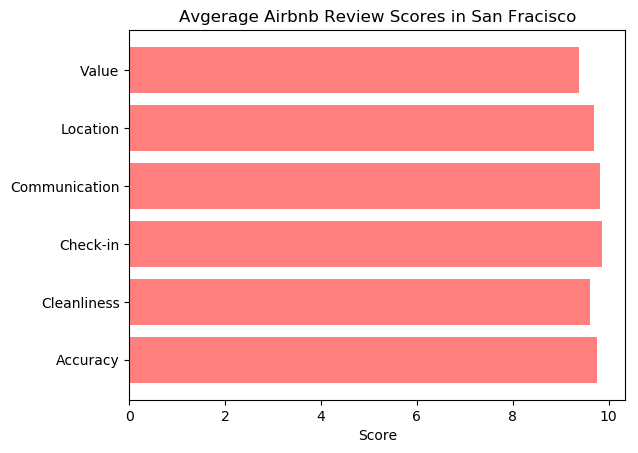

In [219]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ["Accuracy", "Cleanliness", "Check-in", "Communication", "Location", "Value"]
y_pos = np.arange(len(objects))
performance = [9.759248029, 9.611734384, 9.852463988, 9.825829923, 9.688400303, 9.383320697]


plt.barh(y_pos, performance, align='center', alpha=0.5, color="red" )
plt.yticks(y_pos, objects)
plt.xlabel('Score')
plt.title('Avgerage Airbnb Review Scores in San Fracisco')


plt.show()



# Seperate average for price and income by if they got a 10 rating or not


In [243]:
def perfectScore(index, numPerfects):
    ans = False
    counter = 0
    if review_scores_rating[index] == 100:
        counter += 1
    if review_scores_accuracy[index] == 10:
        counter += 1
    if review_scores_cleanliness[index] == 10:
        counter += 1
    if review_scores_checkin[index] == 10:
        counter += 1
    if review_scores_communication[index] == 10:
        counter += 1
    if review_scores_location[index] == 10:
        counter += 1
    if review_scores_value[index] == 10:
        counter += 1
    if counter >= numPerfects:
        ans = True
    return ans

    
i=2
print(perfectScore(i,5))
print(review_scores_rating[i])
print(review_scores_accuracy[i])
print(review_scores_cleanliness[i])
print(review_scores_checkin[i])
print(review_scores_communication[i])
print(review_scores_location[i])
print(review_scores_value[i])

True
98.0
10.0
10.0
10.0
10.0
10.0
9.0


# Seperate Income into 10 and not 10 groups

In [288]:
income_cleansed10 = np.array([]) 
income_cleansed10_avg = np.array([]) 
income_cleansed_not10 = np.array([]) 
income_cleansed_not10_avg = np.array([]) 
for index, element in enumerate(income_cleansed):
    if perfectScore(index,7):
        income_cleansed10 = np.append(income_cleansed10, element)
        income_cleansed_not10 = np.append(income_cleansed_not10, None)#so we maintain proper indexing
        if element != None:
            income_cleansed10_avg = np.append(income_cleansed10_avg, element) #exclude Nans for average calc
    elif not perfectScore(index,7):
        income_cleansed_not10 = np.append(income_cleansed_not10, element)
        income_cleansed10 = np.append(income_cleansed10, None) #so we maintain proper indexing
        if element != None:
            income_cleansed_not10_avg = np.append(income_cleansed_not10_avg, element) #exclude Nans for average calc

In [289]:
np.mean(income_cleansed10_avg)

1.3162898515797086

In [290]:
np.mean(income_cleansed_not10_avg)

0.9488182965700044

# Seperate Price into 10 and not 10 groups

In [296]:
price_cleansed10 = np.array([]) 
price_cleansed10_avg = np.array([]) 
price_cleansed_not10 = np.array([]) 
price_cleansed_not10_avg = np.array([]) 
for index, element in enumerate(price_cleansed):
    if perfectScore(index,7):
        price_cleansed10 = np.append(price_cleansed10, element)
        price_cleansed_not10 = np.append(price_cleansed_not10, None)#so we maintain proper indexing
        if element != None:
            price_cleansed10_avg = np.append(price_cleansed10_avg, element) #exclude Nans for average calc
    elif not perfectScore(index,7):
        price_cleansed_not10 = np.append(price_cleansed_not10, element)
        price_cleansed10 = np.append(price_cleansed10, None) #so we maintain proper indexing
        if element != None:
            price_cleansed_not10_avg = np.append(price_cleansed_not10_avg, element) #exclude Nans for average calc

In [297]:
np.mean(price_cleansed10_avg)

1.1142736698738087

In [298]:
np.mean(price_cleansed_not10_avg)

0.9815083504825491

# Multiple Regression for Income10 

In [292]:
#multiple regression for every listing
a = mult_reg(income_cleansed10).summary()
a

/Users/lizzyhanley/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1554: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 22 Jan 2020   Prob (F-statistic):                nan
Time:                        23:06:13   Log-Likelihood:                -2344.2
No. Observations:                1096   AIC:                             4690.
Df Residuals:                    1095   BIC:                             4695.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   5.86e-06     21.203      0.000       0.000       0.000
x1             0.0124      0.001     21.203      0.000       0.011       0.014
x2             0.0012   5.86e-05     21.203      0.000       0.001       0.001
x3             0.0012   5.86e-05     21.203      0.000       0.001       0.001
x4             0.0012   5.86e-05     21.203      0.000       0.001       0.001
x5             0.0012   5.86e-05     21.203      0.000       0.001       0.001
x6             0.0012   5.86e-05     21.203      0.000       0.001       0.001
x7             0.0012   5.86e-05     21.203      0.000       0.001       0.001
==============================================================================
Omnibus:                     1906.509   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1550787.288
Skew:                          11.514   Prob(JB):                         0.00
Kurtosis:                     185.835   Cond. No.                    1.30e+113
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.87e-220. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Multiple Regression for Income_NOT10 

In [293]:
#multiple regression for every listing
a = mult_reg(income_cleansed_not10).summary()
a

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     29.03
Date:                Wed, 22 Jan 2020   Prob (F-statistic):           2.91e-13
Time:                        23:06:21   Log-Likelihood:                -8069.9
No. Observations:                4947   AIC:                         1.615e+04
Df Residuals:                    4944   BIC:                         1.617e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7129      0.235     -3.039      0.002      -1.173      -0.253
x1             0.0150      0.003      4.659      0.000       0.009       0.021
x2             0.0050      0.005      0.928      0.353      -0.006       0.015
x3             0.0050      0.005      0.928      0.353      -0.006       0.015
x4             0.0050      0.005      0.928      0.353      -0.006       0.015
x5             0.0050      0.005      0.928      0.353      -0.006       0.015
x6             0.0050      0.005      0.928      0.353      -0.006       0.015
x7             0.0050      0.005      0.928      0.353      -0.006       0.015
==============================================================================
Omnibus:                     9416.326   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         42524593.643
Skew:                          14.148   Prob(JB):                         0.00
Kurtosis:                     456.326   Cond. No.                     5.71e+80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.45e-154. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Multiple Regression for Price10 

In [294]:
#multiple regression for every listing
a = mult_reg(price_cleansed10).summary()
a

/Users/lizzyhanley/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1554: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Wed, 22 Jan 2020   Prob (F-statistic):                nan
Time:                        23:06:45   Log-Likelihood:                -1714.3
No. Observations:                1096   AIC:                             3431.
Df Residuals:                    1095   BIC:                             3436.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001    3.3e-06     31.890      0.000    9.86e-05       0.000
x1             0.0105      0.000     31.890      0.000       0.010       0.011
x2             0.0011    3.3e-05     31.890      0.000       0.001       0.001
x3             0.0011    3.3e-05     31.890      0.000       0.001       0.001
x4             0.0011    3.3e-05     31.890      0.000       0.001       0.001
x5             0.0011    3.3e-05     31.890      0.000       0.001       0.001
x6             0.0011    3.3e-05     31.890      0.000       0.001       0.001
x7             0.0011    3.3e-05     31.890      0.000       0.001       0.001
==============================================================================
Omnibus:                     1720.090   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           843274.557
Skew:                           9.447   Prob(JB):                         0.00
Kurtosis:                     137.569   Cond. No.                    1.30e+113
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.87e-220. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Multiple Regression for Pirce_NOT10 

In [295]:
#multiple regression for every listing
a = mult_reg(price_cleansed10).summary()
a

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Wed, 22 Jan 2020   Prob (F-statistic):                nan
Time:                        23:06:47   Log-Likelihood:                -1714.3
No. Observations:                1096   AIC:                             3431.
Df Residuals:                    1095   BIC:                             3436.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001    3.3e-06     31.890      0.000    9.86e-05       0.000
x1             0.0105      0.000     31.890      0.000       0.010       0.011
x2             0.0011    3.3e-05     31.890      0.000       0.001       0.001
x3             0.0011    3.3e-05     31.890      0.000       0.001       0.001
x4             0.0011    3.3e-05     31.890      0.000       0.001       0.001
x5             0.0011    3.3e-05     31.890      0.000       0.001       0.001
x6             0.0011    3.3e-05     31.890      0.000       0.001       0.001
x7             0.0011    3.3e-05     31.890      0.000       0.001       0.001
==============================================================================
Omnibus:                     1720.090   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           843274.557
Skew:                           9.447   Prob(JB):                         0.00
Kurtosis:                     137.569   Cond. No.                    1.30e+113
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.87e-220. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""